## Inference and Metropolis Alogrithm   

Consider the data `data.npy`. Assume $X$ is distributed according to a Normal distribution as:

$$ f_X(x|\mu, \sigma) = \dfrac{1}{\sqrt{2\pi \sigma^2}} \cdot e^{-\dfrac{(x-\mu)^2}{2\sigma^2}} $$

where $\mu$ and $\sigma$ are the mean and standard deviation of the distribution and are given by:

$$f_{prior}(\mu) = \dfrac{1}{\sqrt{2\pi s^2}} \cdot e^{-\dfrac{(\mu- m)^2}{2 s^2}} \quad \quad \text{with   } m = 4  \text{  ,  } s = 2 $$


$$ f_{prior}(\sigma) = \dfrac{\beta^{\alpha}}{\Gamma(\alpha)} \cdot \bigg( \dfrac{1}{\sigma} \bigg)^{\alpha+1} \cdot e^{-\dfrac{\beta}{\sigma}} \quad \quad \text{with   } \alpha = 2  \text{  ,  } \beta = 1 $$


---

Estimate $\mu$, $\sigma$ as posterior averages (with errors given by posterior standard deviations) from the data, using **Metropolis algorithm** to sample. In other words, sample:

$$f(\mu, \sigma|x) \quad \propto \quad f_X(x|\mu, \sigma) \cdot f_{prior}(\mu) \cdot f_{prior}(\sigma)$$

using Metropolis algorithm. The proposal step $T(\mu', \sigma'|\mu, \sigma)$ can be any random move such that:

$$ 
\mu  \quad \to \quad \mu'
\\
\sigma  \quad \to \quad \sigma' 
$$


For instance, $(\mu', \sigma')$ are sampled normally around $(\mu,\sigma)$ with a standard deviation $\tau$:
$$ (\mu' , \sigma') \sim \mathcal{N} \big[(\mu, \sigma), \tau^2 \cdot \mathbb{I} \big] $$


---


### Metropolis Algorithm

The Metropolis algorithm is a Markov Chain Monte Carlo (MCMC) algorithm that generates a sequence of random variables $\{X_n\}$ that are distributed according to the target distribution $f_X(x)$, given a proposal distribution $T(x'|x)$.

The algorithm is as follows:
* Initialize $X_0$.
* For $n=1,2,3,...$:
    * Sample $X_n$ from $T(X_n|X_{n-1})$.
    * Accept $X_n$ with probability $\min \bigg(1, \dfrac{f(X_n)}{f(X_{n-1})} \bigg)$.
    * If $X_n$ is accepted, set $X_{n+1} = X_n$, otherwise set $X_{n+1} = X_{n-1}$.

The algorithm is guaranteed to converge to the target distribution $f_X(x)$, but the convergence is slow. 

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.special

import scipy.stats

In [2]:
#Define all the functions needed for the Metropolis algorithm

def log_likelihood(x, mu, sigma):
    #return np.sum(np.log( (1/(np.sqrt(2*np.pi*sigma**2))) * np.exp(-((x-mu)**2)/(2*sigma**2)) ) )
    
    likelihood = scipy.stats.norm.pdf(x, loc=mu, scale=sigma)
    return np.sum(np.log(likelihood))

def prior_mu(mu, m , s):
    #return ((1/(np.sqrt(2*np.pi*s**2))) * np.exp(-((x-m)**2)/(2*s**2)))
    
    prior = scipy.stats.norm.pdf(mu, loc=m, scale=s)
    return prior

def prior_sigma(x, alpha, beta):
    prior = (beta**(alpha) / scipy.special.gamma(alpha)) * (1 / x**(alpha + 1)) * np.exp(-beta / x) 
    return prior


In [3]:
#load the data from the file

dataset = np.load('data.npy')

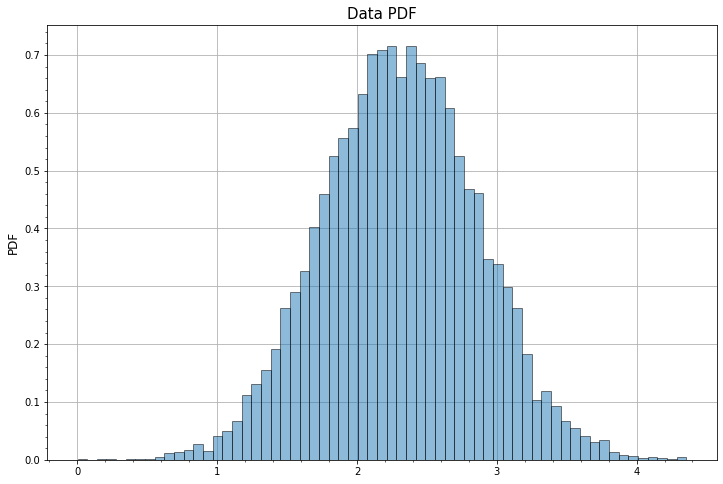

In [4]:
# Visualizing the data

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.hist(dataset, bins='fd', density=True, alpha = 0.5, edgecolor='black', zorder = 2)
ax.grid(zorder = 1)
ax.minorticks_on()
ax.set_title('Data PDF', fontsize = 15)
ax.set_ylabel('PDF', fontsize = 12)
plt.show()

In [5]:
m = 4; s = 2; alpha = 2; beta = 1

In [6]:
#Metropolis algorithm loop
    
n_accepted_values = 1000
maxiter = 100000

# Initial values
current_sigma = 2
current_mu = 2


# List to store the values
sigma_list = []
mu_list = []

i = 0

while (len(sigma_list) < n_accepted_values) and (i < maxiter):
    i += 1
    
    #proposals
    proposal_mu = np.random.normal(loc=current_mu, scale=0.1)
    proposal_sigma = np.random.normal(loc=current_sigma, scale=0.1)
    
    #posterior with the proposal values
    propos_post = log_likelihood(dataset, proposal_mu, proposal_sigma) + np.log(prior_mu(proposal_mu, m, s)) + np.log(prior_sigma(proposal_sigma, alpha, beta))
    #posterior with the current values
    current_post =  log_likelihood(dataset, current_mu, current_sigma) + np.log(prior_mu(current_mu, m, s)) + np.log(prior_sigma(current_sigma, alpha, beta))
    
    #computing the acceptance probability
    acceptance_prob = np.min([1 , np.exp( propos_post - current_post) ])
    
    #cutoff to accept or reject the proposal
    cutoff = np.random.uniform(0,1)
    
    if cutoff < acceptance_prob:
        current_sigma = proposal_sigma
        current_mu = proposal_mu
        sigma_list.append(current_sigma)
        mu_list.append(current_mu)


<ipython-input-6-f0436c45b814>:30: RuntimeWarning: overflow encountered in exp
  acceptance_prob = np.min([1 , np.exp( propos_post - current_post) ])


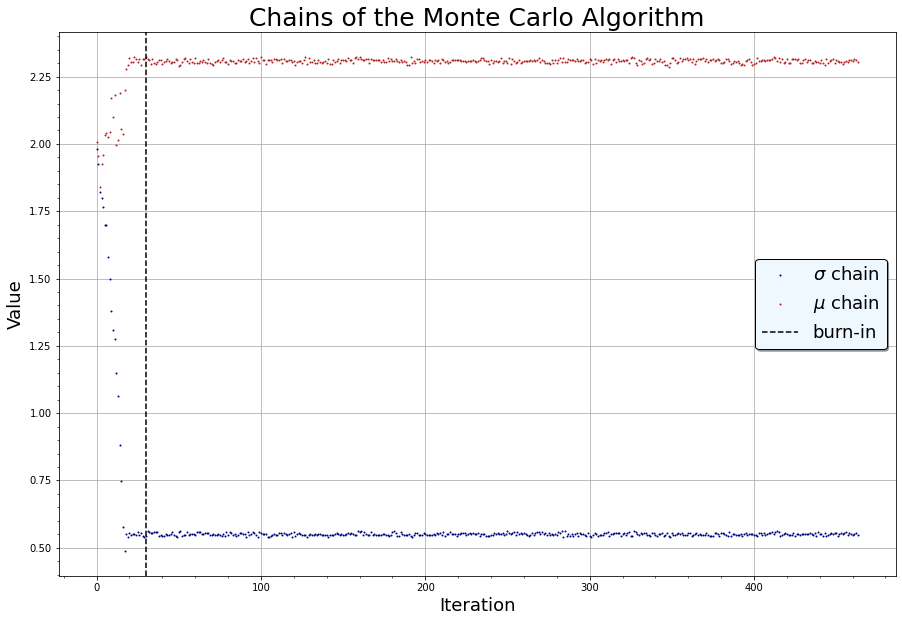

In [7]:
#Plotting the chains results

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.scatter(x = np.arange(len(sigma_list)), y = sigma_list, s=1, color = 'navy', zorder = 2, label = '$ \\sigma$ chain')
ax.scatter(x = np.arange(len(mu_list)), y = mu_list, s=1, color = 'firebrick', zorder = 2, label = '$ \\mu$ chain')

ax.grid(zorder = 1)
ax.minorticks_on()

ax.axvline(x = 30, color = 'black', linestyle = '--', zorder = 3, label = 'burn-in')
ax.set_title('Chains of the Monte Carlo Algorithm', fontsize = 25)
ax.set_ylabel('Value', fontsize = 18)
ax.set_xlabel('Iteration', fontsize = 18)
ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize = 18)

plt.show()

Given our results we consider a burn-in of $$ steps, in the following we plot the posterior for our samples.

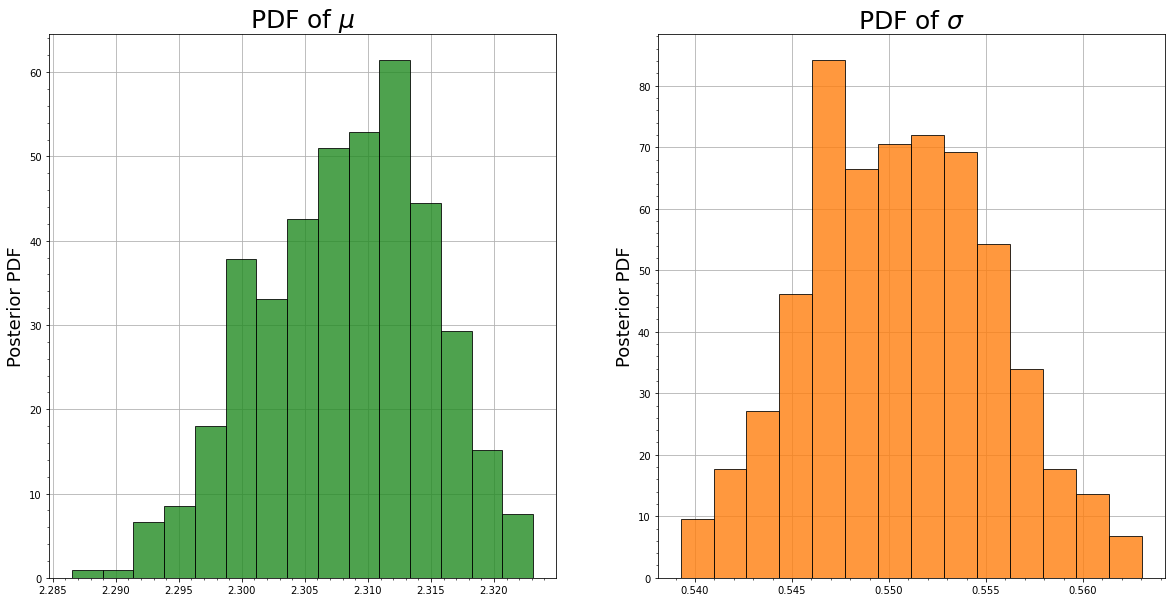

In [8]:
#Plotting the posterior PDFs

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

counts_mu, edges_mu, _ = ax[0].hist(mu_list[30:], bins='fd', density=True, alpha = 0.8, color='forestgreen', edgecolor='black', zorder = 2)
ax[0].grid(zorder = 1)
ax[0].minorticks_on()
ax[0].set_title('PDF of $\\mu$', fontsize = 25)
ax[0].set_ylabel('Posterior PDF', fontsize = 18)


counts_sigma, edges_sigma, _ = ax[1].hist(sigma_list[30:], bins='fd', density=True, alpha = 0.8, color='C1', edgecolor='black', zorder = 2)
ax[1].grid(zorder = 1)
ax[1].minorticks_on()
ax[1].set_title('PDF of $\\sigma$', fontsize = 25)
ax[1].set_ylabel('Posterior PDF', fontsize = 18)

plt.show()




In [9]:
idx_max_sigma = np.argmax(counts_sigma)
idx_max_mu = np.argmax(counts_mu)

max_sigma = edges_sigma[idx_max_sigma] + (edges_sigma[idx_max_sigma + 1] - edges_sigma[idx_max_sigma]) / 2
max_mu = edges_mu[idx_max_mu] + (edges_mu[idx_max_mu + 1] - edges_mu[idx_max_mu]) / 2

print(f'The infered value for mu is {max_mu:.4f} and the infered sigma is {max_sigma:.4f}')

The infered value for mu is 2.3121 and the infered sigma is 0.5469


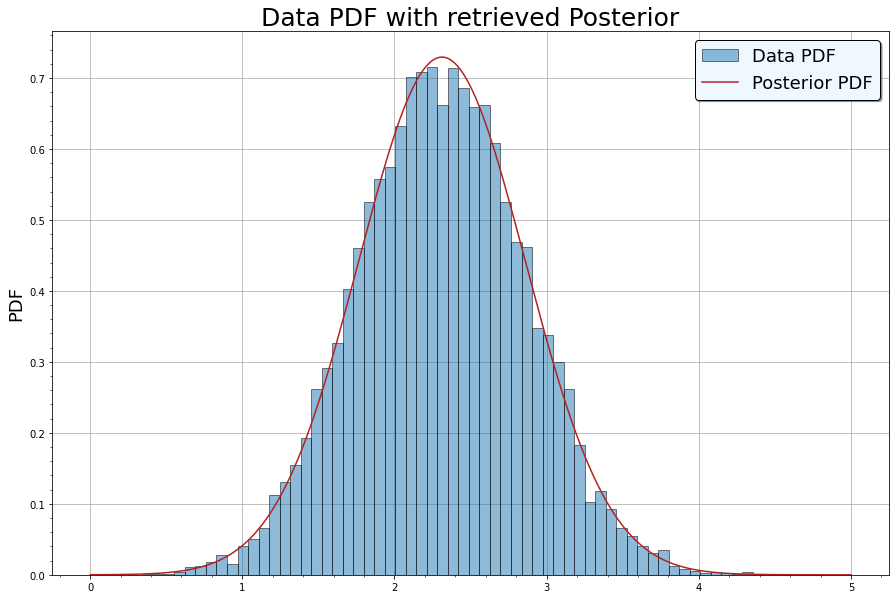

In [10]:
x_axis = np.linspace(0, 5, 1000)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.hist(dataset, bins='fd', density=True, alpha = 0.5, edgecolor='black', zorder = 2, label = 'Data PDF')
ax.grid(zorder = 1)
ax.minorticks_on()

ax.set_title('Data PDF with retrieved Posterior', fontsize = 25)
ax.set_ylabel('PDF', fontsize = 18)

ax.plot(x_axis, scipy.stats.norm.pdf(x_axis, loc=max_mu, scale=max_sigma), color = 'firebrick', zorder = 3, label = 'Posterior PDF')
ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize = 18)    
plt.show()


---
The proposal step $T(\mu', \sigma'|\mu, \sigma)$ is normal with step sixe $\epsilon$:

$$
\mu \quad \to \quad \mu' \sim \mathcal{N}(\mu, \epsilon^2)

\\

\sigma \quad \to \quad \sigma' \sim \mathcal{N}(\sigma, \epsilon^2)

$$


Try different step sizes, 

$$\epsilon = [10^{-5}, 10^{−4},10^{−3}, 10^{−2}, 10^{−1}, 0.5]$$

and observe qualitatively the behavior of the chain and the convergence speed

---

<ipython-input-11-572ad1fdaafb>:37: RuntimeWarning: invalid value encountered in log
  propos_post = log_likelihood(dataset, proposal_mu, proposal_sigma) + np.log(prior_mu(proposal_mu, m, s)) + np.log(prior_sigma(proposal_sigma, alpha, beta))
<ipython-input-2-869e301a1984>:7: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(likelihood))
<ipython-input-11-572ad1fdaafb>:37: RuntimeWarning: divide by zero encountered in log
  propos_post = log_likelihood(dataset, proposal_mu, proposal_sigma) + np.log(prior_mu(proposal_mu, m, s)) + np.log(prior_sigma(proposal_sigma, alpha, beta))
<ipython-input-2-869e301a1984>:16: RuntimeWarning: overflow encountered in exp
  prior = (beta**(alpha) / scipy.special.gamma(alpha)) * (1 / x**(alpha + 1)) * np.exp(-beta / x)
<ipython-input-2-869e301a1984>:16: RuntimeWarning: overflow encountered in double_scalars
  prior = (beta**(alpha) / scipy.special.gamma(alpha)) * (1 / x**(alpha + 1)) * np.exp(-beta / x)


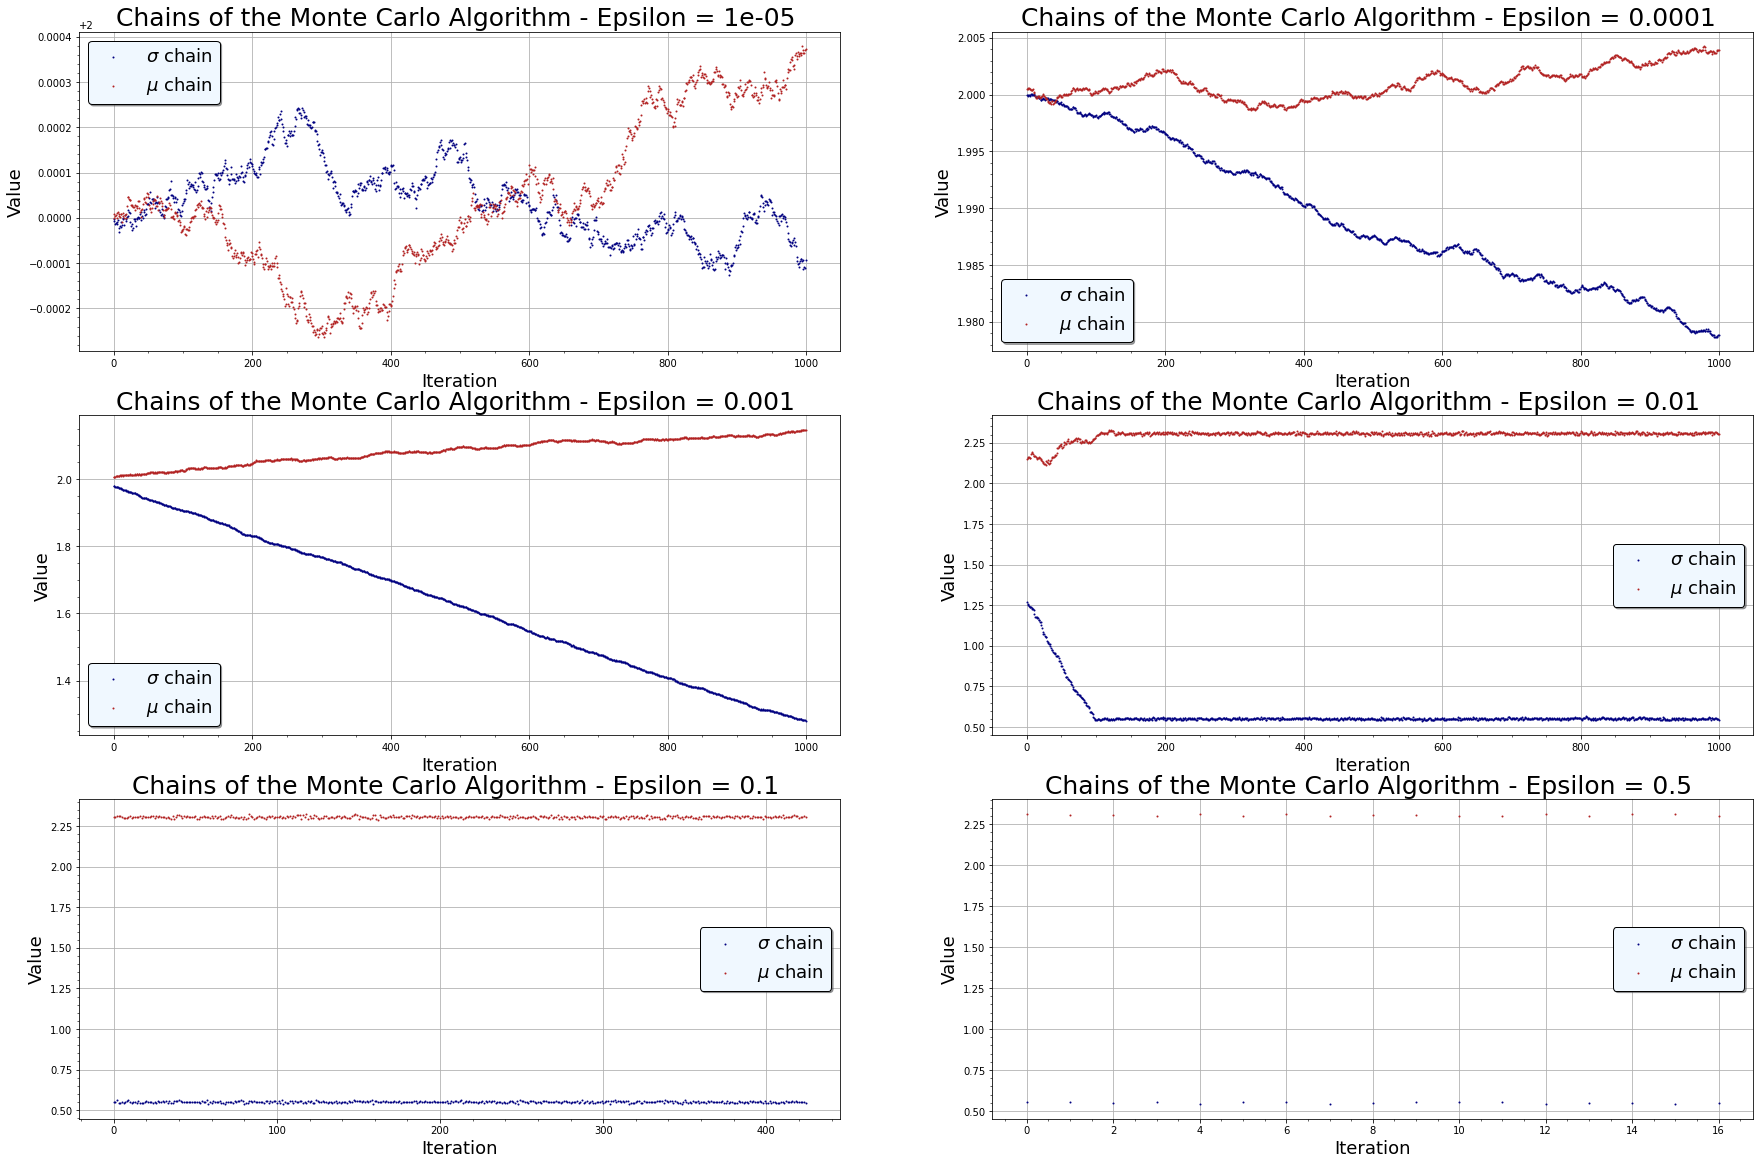

In [11]:
import time

time_values = {}

#Metropolis algorithm loop
    
n_accepted_values = 1000
maxiter = 100000

# Initial values
current_sigma = 2
current_mu = 2

eps_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5]
fig, ax = plt.subplots(3, 2, figsize=(30, 20))

ind_plot_list= [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for j,eps in enumerate(eps_list):
    
    
    # List to store the values
    sigma_list = []
    mu_list = []

    i = 0
    start = time.time()

    while (len(sigma_list) < n_accepted_values) and (i < maxiter):
        i += 1
        
        #proposals
        proposal_mu = np.random.normal(loc=current_mu, scale=eps)
        proposal_sigma = np.random.normal(loc=current_sigma, scale=eps)
        
        #posterior with the proposal values
        propos_post = log_likelihood(dataset, proposal_mu, proposal_sigma) + np.log(prior_mu(proposal_mu, m, s)) + np.log(prior_sigma(proposal_sigma, alpha, beta))
        #posterior with the current values
        current_post =  log_likelihood(dataset, current_mu, current_sigma) + np.log(prior_mu(current_mu, m, s)) + np.log(prior_sigma(current_sigma, alpha, beta))
        
        #computing the acceptance probability
        acceptance_prob = np.min([1 , np.exp( propos_post - current_post) ])
        
        #cutoff to accept or reject the proposal
        cutoff = np.random.uniform(0,1)
        
        if cutoff < acceptance_prob:
            current_sigma = proposal_sigma
            current_mu = proposal_mu
            sigma_list.append(current_sigma)
            mu_list.append(current_mu)
    
    end = time.time()
    
    #Keeping the time
    
    time_values[eps] = (end - start)
       
    
    #Plotting the chains results



    ax[ind_plot_list[j]].scatter(x = np.arange(len(sigma_list)), y = sigma_list, s=1, color = 'navy', zorder = 2, label = '$ \\sigma$ chain')
    ax[ind_plot_list[j]].scatter(x = np.arange(len(mu_list)), y = mu_list, s=1, color = 'firebrick', zorder = 2, label = '$ \\mu$ chain')

    ax[ind_plot_list[j]].grid(zorder = 1)
    ax[ind_plot_list[j]].minorticks_on()

    #ax[j].axvline(x = 30, color = 'black', linestyle = '--', zorder = 3, label = 'burn-in')
    ax[ind_plot_list[j]].set_title(f'Chains of the Monte Carlo Algorithm - Epsilon = {eps} ', fontsize = 25)
    ax[ind_plot_list[j]].set_ylabel('Value', fontsize = 18)
    ax[ind_plot_list[j]].set_xlabel('Iteration', fontsize = 18)
    ax[ind_plot_list[j]].legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize = 18)



In [29]:
print('Measured time for each epsilon value:')

for i in range(len(time_values)):
    print('\nEpsilon value = ', list(time_values.keys())[i] , ' - Time = ', list(time_values.values())[i])

Measured time for each epsilon value:

Epsilon value =  1e-05  - Time =  1.7923128604888916

Epsilon value =  0.0001  - Time =  2.021695137023926

Epsilon value =  0.001  - Time =  3.2975990772247314

Epsilon value =  0.01  - Time =  6.964639186859131

Epsilon value =  0.1  - Time =  211.96871089935303

Epsilon value =  0.5  - Time =  187.14807295799255
